In [1]:
import os
import gc
import torch
import time
import torch.nn as nn
import numpy as np
import nibabel as nib
import statsmodels.api as sm
from os.path import join as pjoin
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import zscore
import joblib
from scipy.optimize import curve_fit

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from utils import train_data_normalization, Timer, net_size_info, conv2_labels, get_roi_data, ReceptiveFieldProcessor

In [3]:
subs = [f'sub-0{isub+1}' for isub in range(0, 9)]
inputlayername = 'googlenet-conv2' 
layer = {'name': inputlayername, 'size': net_size_info[inputlayername.replace('raw-', '')]}#alexnet_info[inputlayername]
layername = layer['name']
layername = layername.replace('.','')
layersize = layer['size']
labels = conv2_labels
mask_name = 'primaryvis-in-MMP' #'fixretfloc-in-subj'
test_set_name = 'coco'
fold_indices = [(0, 1000), (1000, 2000), (2000, 3000), (3000, 4000)]
# path settings
work_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
opendata_cifti_pth = '/nfs/z1/userhome/GongZhengXin/NVP/data_upload/NOD/derivatives/ciftify'
# input path
resp_path = pjoin(work_dir, 'prep/brain_response')
voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
image_activations_path = pjoin(work_dir, 'prep/image_activations')
retino_path = pjoin(work_dir, 'build/retinoparams')
guass_path = pjoin(work_dir, 'build/gaussianparams')
avgrf_path = pjoin(work_dir, 'prep/image_mask')
# save out path
performance_path = pjoin(work_dir, 'build/lass-feature-selection/')

# coordinate
# Create grid data
i = np.linspace(-8., 8., layer['size'])
j = np.linspace(8., -8., layer['size'])
i, j = np.meshgrid(i, j)


In [4]:
# Define the 2D Gaussian function
def gaussian_2d(coords, A, x_0, y_0, sigma_x, sigma_y,C):
    i, j = coords
    return A * np.exp(-((i - x_0)**2 / (2 * sigma_x**2) + (j - y_0)**2 / (2 * sigma_y**2))) + C

def adjust_RF(receptive_field):
    cur_receptive_field = receptive_field.copy()
    cur_receptive_field = cur_receptive_field + np.abs(np.min(cur_receptive_field, None)) + 1
    thres = np.min(cur_receptive_field) + 0.5*(np.max(cur_receptive_field) - np.min(cur_receptive_field)) # 
    # if np.mean(receptive_field < thres) < 0.1:
    #     thres = np.mean(receptive_field)
    cur_receptive_field[cur_receptive_field < thres] = 0
    cur_receptive_field = cur_receptive_field / (cur_receptive_field.sum() + 1e-20)
    # if (~np.isfinite(cur_receptive_field)).any():
    #     print('use full gaussian')
    #     cur_receptive_field = receptive_field + np.abs(np.min(receptive_field, None))
    #     cur_receptive_field = cur_receptive_field / (cur_receptive_field.sum() + 1e-20)
    return cur_receptive_field

def compute_theta(x, y):
    # Calculate angle using arctan2
    theta_rad = np.arctan2(y, x)
    
    # Rotate by 90 degrees to align with y-axis
    theta_rad = np.pi/2 - theta_rad
    
    # Convert to degrees and handle the range
    theta_deg = np.degrees(theta_rad)
    if theta_deg > 180:
        theta_deg -= 360

    return theta_deg

## generate receptive field

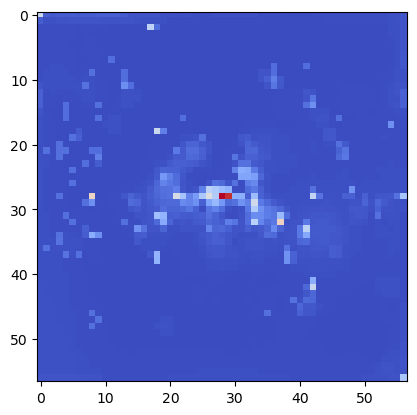

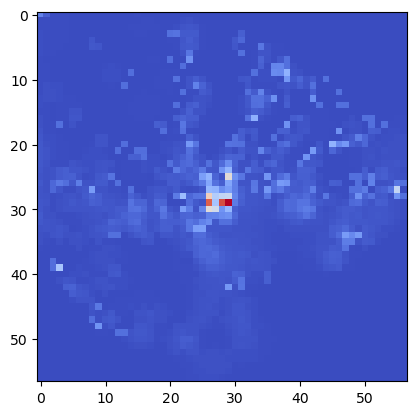

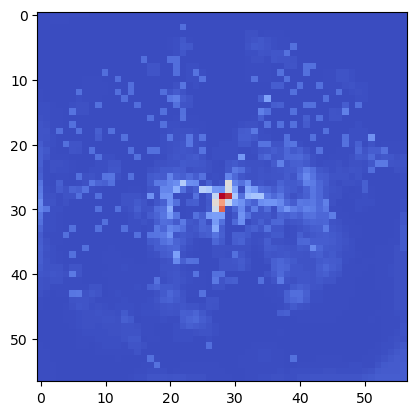

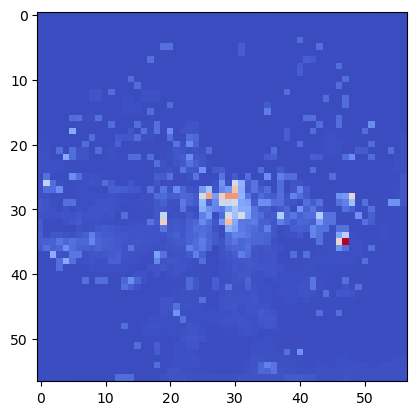

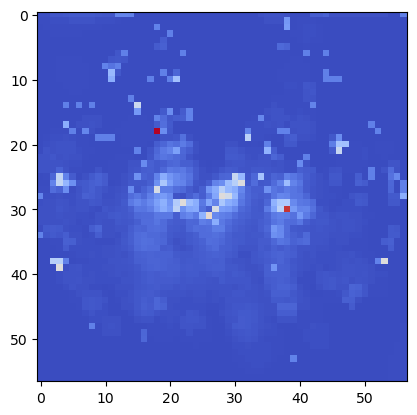

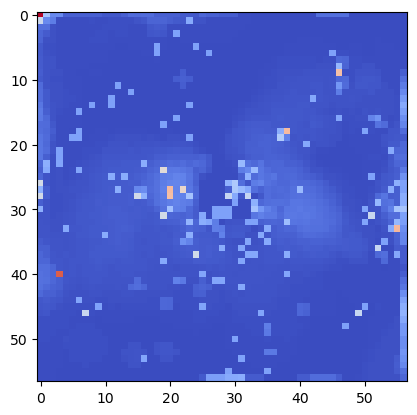

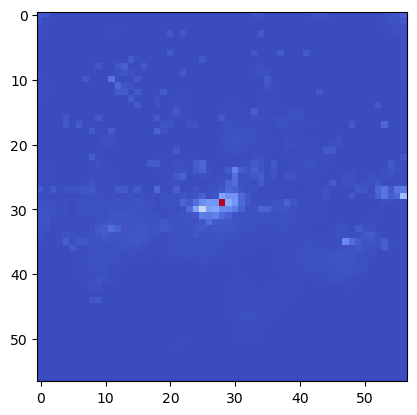

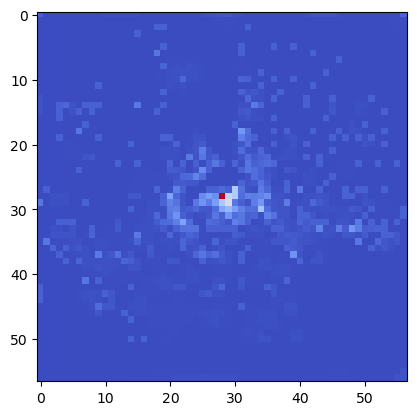

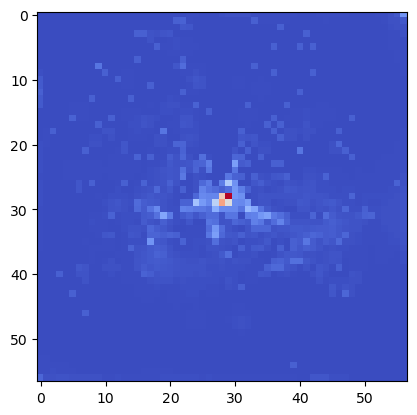

In [22]:
opendata_cifti_pth = '/nfs/z1/userhome/GongZhengXin/NVP/data_upload/NOD/derivatives/ciftify'
for sub in subs:
    # getting retinotopic voxels
    sub_prf_file = os.path.join(opendata_cifti_pth, sub, 'results/ses-prf_task-prf/ses-prf_task-prf_params.dscalar.nii')
    prf_r2 = nib.load(sub_prf_file).get_fdata()[3, :]
    r2_thres = 10
    voxel_mask = np.where(prf_r2 > r2_thres)[0]

    # select ROI names
    evc_pool = ['V1']
    # aggregate ROI vertices
    roi_name = [__  for _ in [evc_pool] for __ in _]
    # form ROI mask
    selection_mask = np.sum([get_roi_data(None, _) for _ in roi_name], axis=0)
    # trsnfer to indices in cifti space
    voxel_indices = [_ for _ in np.where(selection_mask==1)[0] if _ in voxel_mask]

    retino_info = nib.load(sub_prf_file).get_fdata()
    n_vertices = retino_info.shape[-1]
    # we need to transfer the params into (x,y,size) model
    trans_retinotopy_params = np.zeros((n_vertices, 3))
    trans_retinotopy_params[:,0] = np.cos(retino_info[0, 0:n_vertices]/180*np.pi)*retino_info[1, 0:n_vertices]*16/200
    trans_retinotopy_params[:,1] = np.sin(retino_info[0, 0:n_vertices]/180*np.pi)*retino_info[1, 0:n_vertices]*16/200
    trans_retinotopy_params[:,2] = retino_info[2, 0:n_vertices]*16/200

    # # 绘图
    # fig, ax = plt.subplots()
    # for x, y, r in trans_retinotopy_params[voxel_indices,:]:
    #     circle = plt.Circle((x, y), r, edgecolor='gray', facecolor='none')
    #     ax.add_artist(circle)

    # ax.set_xlim(-8, 8)
    # ax.set_ylim(-8, 8)
    # ax.set_aspect('equal', 'box')
    # plt.show()

    pos2vf = lambda x : (x-int(layersize/2)) * 16 / layersize
    fwhm2sigma = lambda x : x / 2.354282

    receptive_field = np.zeros((57, 57))
    for voxel in voxel_indices:
        params = [1,*trans_retinotopy_params[voxel],trans_retinotopy_params[voxel,2], 0]
        receptive_field += adjust_RF(gaussian_2d((i, j), *params))
        # receptive_field += 0.01*prf_r2[voxel]*adjust_RF(gaussian_2d((i, j), *params))
        # receptive_field += (ReceptiveFieldProcessor(16, *trans_retinotopy_params[voxel]).get_spatial_kernel(57))
    receptive_field = receptive_field / receptive_field.sum()
    np.save(pjoin(avgrf_path, f'{sub}_prior-average-receptivefield.npy'), receptive_field)
    # data = receptive_field
    # max_pos = np.unravel_index(np.argmax(data, axis=None), data.shape)
    # half_max = 0.5*np.max(data, axis=None)
    # # initialize settings
    # A_init, C_init = 1, np.min(data, axis=None)
    # # x_init, y_init = pos2vf(max_pos[0]), pos2vf(max_pos[1])
    # x_poses, y_poses = np.where(data > np.percentile(data, 90))
    # x_init, y_init = pos2vf(np.mean(x_poses)), pos2vf(np.mean(y_poses))

    # xsigma_init, ysigma_init = fwhm2sigma(np.sum(data[:, max_pos[1]]>=half_max)), fwhm2sigma(np.sum(data[max_pos[0], :]>=half_max))

    # param_initial = [A_init, x_init, y_init, xsigma_init, ysigma_init, C_init]

    # bound =([0, -20, -20, 0, 0, -np.inf], [np.inf, 20, 20, np.inf, np.inf, np.inf])
    # params, covariance = curve_fit(gaussian_2d, (i.ravel(), j.ravel()), data.ravel(), p0=param_initial, bounds=bound)
    # A, x_0, y_0, xsigma, ysigma, C = params
    # fitted_data = gaussian_2d((i, j), A, x_0, y_0, xsigma, ysigma, C)

    plt.imshow(receptive_field, cmap='coolwarm')
    plt.show()

In [219]:
pos2vf = lambda x : (x-int(layersize/2)) * 16 / layersize
fwhm2sigma = lambda x : x / 2.354282
for sub in subs:
    guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{layername}_Gauss.npy'), allow_pickle=True)[0]

    gaussian_mask = np.zeros((57, 57))
    
    for voxel, params in guassparams.items():
        gaussian_mask += adjust_RF(gaussian_2d((i, j), *params))        
        # gaussian_mask += 0.01*prf_r2[voxel]*adjust_RF(gaussian_2d((i, j), *params))

    gaussian_mask = gaussian_mask / gaussian_mask.sum()
    np.save(pjoin(avgrf_path, f'{sub}_average-receptivefield.npy'), gaussian_mask)
    # data = gaussian_mask
    # max_pos = np.unravel_index(np.argmax(data, axis=None), data.shape)
    # half_max = 0.5*np.max(data, axis=None)
    # # initialize settings
    # A_init, C_init = 1, np.min(data, axis=None)
    # # x_init, y_init = pos2vf(max_pos[0]), pos2vf(max_pos[1])
    # x_poses, y_poses = np.where(data > np.percentile(data, 90))
    # x_init, y_init = pos2vf(np.mean(x_poses)), pos2vf(np.mean(y_poses))

    # xsigma_init, ysigma_init = fwhm2sigma(np.sum(data[:, max_pos[1]]>=half_max)), fwhm2sigma(np.sum(data[max_pos[0], :]>=half_max))

    # param_initial = [A_init, x_init, y_init, xsigma_init, ysigma_init, C_init]
            
    # bound =([0, -20, -20, 0, 0, -np.inf], [np.inf, 20, 20, np.inf, np.inf, np.inf])
    # params, covariance = curve_fit(gaussian_2d, (i.ravel(), j.ravel()), data.ravel(), p0=param_initial, bounds=bound)
    # A, x_0, y_0, xsigma, ysigma, C = params
    # fitted_data = gaussian_2d((i, j), A, x_0, y_0, xsigma, ysigma, C)
    # np.save(pjoin(avgrf_path, f'{sub}_average-receptivefield.npy'), fitted_data)

## lasso feature selection

### within subject

In [33]:
sub = subs[0]

print(sub, mask_name, layername)
# sub dir
prf_path = pjoin(opendata_cifti_pth, sub, 'results/ses-prf_task-prf')
sub_prf_file = pjoin(prf_path, 'ses-prf_task-prf_params.dscalar.nii')
# save path
if not os.path.exists(pjoin(performance_path, sub)):
    os.makedirs(pjoin(performance_path, sub))

# load and modify
prf_data = nib.load(sub_prf_file).get_fdata()
prf_r2 = prf_data[3,:]
r2_thres = 10
# make mask
voxel_mask = prf_r2 > r2_thres
# transfer mask into indices
voxel_indices = np.where(voxel_mask==1)[0]

# generate ROI in selected voxels
v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxel_indices])
v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxel_indices])
v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxel_indices])
v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxel_indices])

# voxel masks
early_vis_rois = [v1_voxels, v2_voxels, v3_voxels, v4_voxels]
# average receptive field
avg_receptivefield = np.load(pjoin(avgrf_path, f'{sub}_average-receptivefield.npy'))
pri_receptivefield = np.load(pjoin(avgrf_path, f'{sub}_prior-average-receptivefield.npy'))
# load
brain_resp = np.load(pjoin(resp_path, f'{sub}_imagenet_beta.npy'))
activations = np.load(pjoin(image_activations_path, f'{sub}_{layername}.npy'))
coco_activations = np.load(pjoin(image_activations_path, f'{test_set_name}_{layername}.npy'))
print(f'activations shape of {activations.shape}')
if 'conv1' in layername:
    guass_layername = layername.replace('conv1', 'conv2')
    guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'), allow_pickle=True)[0]
    print(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'))
else:
    guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{layername}_Gauss.npy'), allow_pickle=True)[0]

# load, reshape and average the resp
test_resp = np.load(pjoin(resp_path, f'{sub}_{test_set_name}_beta.npy'))
num_trial = test_resp.shape[0]
num_run = int(num_trial/120)
test_resp = test_resp.reshape((num_run, 120, 59412))
mean_test_resp = test_resp.mean(axis=0)

# collect resp and summed to ROI response
roi_brain_resp = np.atleast_2d(brain_resp[:, v1_voxels].sum(axis=1)).T
roi_mean_test_resp = np.atleast_2d(mean_test_resp[:, v1_voxels].sum(axis=1)).T

# normalization
norm_metric = 'session'
roi_brain_resp = train_data_normalization(roi_brain_resp, metric=norm_metric)
# mean_test_resp = zscore(test_resp.mean(axis=0))
roi_mean_test_resp = zscore(roi_mean_test_resp, None)

del test_resp, voxel_mask, brain_resp
gc.collect()

sub-01 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


6974

In [35]:
if layername == 'googlenet-conv2':
    X = activations[:, 0:63, :, :]
    X_test = coco_activations[:, 0:63, :, :]
else:
    X = activations
    X_test = coco_activations

# X_avg = zscore(np.sum(X * (avg_receptivefield), axis=(2,3)))
# X_test_avg = zscore(np.sum(X_test * (avg_receptivefield), axis=(2,3)))

X_avg = zscore(np.sum(X * pri_receptivefield, axis=(2,3)))
X_test_avg = zscore(np.sum(X_test *pri_receptivefield, axis=(2,3)))


y = roi_brain_resp
y_test = roi_mean_test_resp

In [37]:
feature_intersection = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-selection-groupmodel-testonindividuals/priorRF/nod-cross-sub_model-priorRF_features-intersection.npy')
feature_union = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-selection-groupmodel-testonindividuals/priorRF/nod-cross-sub_model-priorRF_features-union.npy')

In [49]:
# 自定义4-fold交叉验证
cv = KFold(n_splits=4, shuffle=False)

# 定义要测试的alpha值的范围
alphas = np.logspace(-4, -1, 30)  # 创建一个覆盖广泛范围的alpha值
scores = []  # 用于存储每个alpha对应的平均交叉验证分数

# 对每个alpha进行评估
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    cv_scores = cross_val_score(lasso, X_avg[:, np.array(feature_union)], y, scoring='r2', cv=cv)
    scores.append(np.mean(cv_scores))


In [55]:
alpha = alphas[np.argmax(scores)]
lr = LinearRegression(n_jobs=10)
cv_scores = cross_val_score(lr, X_avg[:, np.array(feature_union)], y, scoring='r2', cv=cv)
cv_scores, cv_scores.mean()

(array([ 0.02371457,  0.00071145,  0.00565441, -0.00523876]),
 0.006210416346576403)

In [56]:
alpha = alphas[np.argmax(scores)]
lasso = Lasso(alpha=alpha)
cv_scores = cross_val_score(lasso, X_avg[:, np.array(feature_union)], y, scoring='r2', cv=cv)
cv_scores, cv_scores.mean()

(array([0.02277357, 0.00906385, 0.00975471, 0.01165193]), 0.013311014810107213)

In [53]:
lasso = Lasso(alpha=alpha)
lasso.fit(X_avg[:, np.array(feature_union)], y)

Lasso(alpha=0.02395026619987486)

In [54]:
lasso.coef_

array([-0.        , -0.        ,  0.01856527,  0.        , -0.        ,
       -0.04516438, -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.00223906, -0.00100018,
       -0.        ,  0.        ,  0.        , -0.0434677 , -0.        ,
       -0.        , -0.        , -0.00374846, -0.00258314,  0.        ,
       -0.00835746,  0.        , -0.        , -0.        , -0.        ])

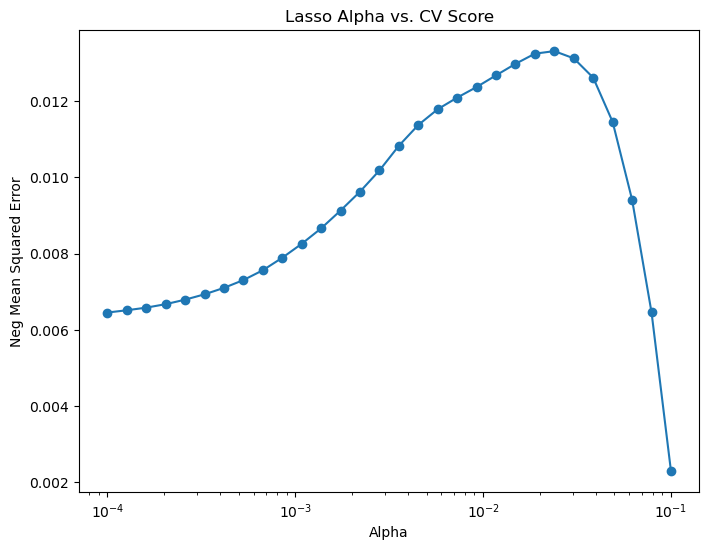

In [50]:
# 绘制alpha与交叉验证分数的关系图
plt.style.use('default')
plt.figure(figsize=(8, 6))
plt.plot(alphas, scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Neg Mean Squared Error')
plt.title('Lasso Alpha vs. CV Score')
plt.show()

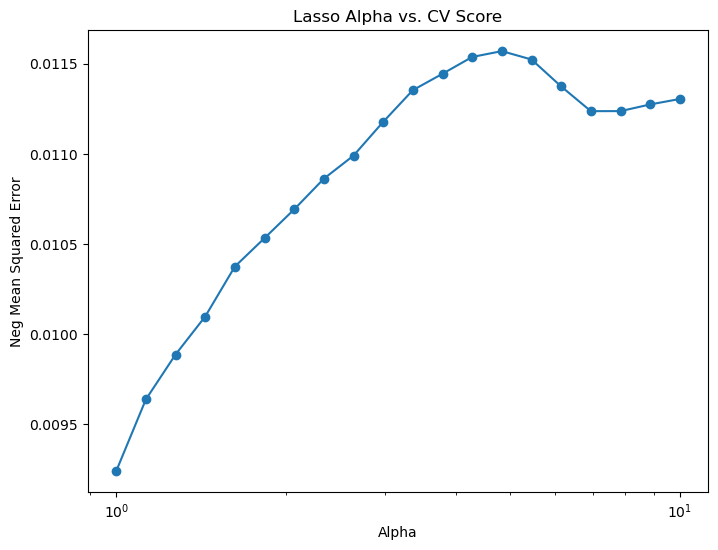

In [21]:
# 绘制alpha与交叉验证分数的关系图
plt.style.use('default')
plt.figure(figsize=(8, 6))
plt.plot(alphas, scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Neg Mean Squared Error')
plt.title('Lasso Alpha vs. CV Score')
plt.show()

In [14]:
alphas[-3::]

array([ 2.97635144,  5.45559478, 10.        ])

In [15]:
alphas

array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01])

In [47]:
np.save('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lass-feature-selection/allsub-alphas.npy', np.array(max_alphas))

### concatenate subjects (cross subjects)

In [23]:
concate_X, concate_X_test = [], []
concate_y, concate_y_test = [], []
for sub in subs:

    print(sub, mask_name, layername)
    # sub dir
    prf_path = pjoin(opendata_cifti_pth, sub, 'results/ses-prf_task-prf')
    sub_prf_file = pjoin(prf_path, 'ses-prf_task-prf_params.dscalar.nii')
    # save path
    if not os.path.exists(pjoin(performance_path, sub)):
        os.makedirs(pjoin(performance_path, sub))

    # load and modify
    prf_data = nib.load(sub_prf_file).get_fdata()
    prf_r2 = prf_data[3,:]
    r2_thres = 10
    # make mask
    voxel_mask = prf_r2 > r2_thres
    # transfer mask into indices
    voxel_indices = np.where(voxel_mask==1)[0]

    # generate ROI in selected voxels
    v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxel_indices])
    v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxel_indices])
    v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxel_indices])
    v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxel_indices])

    # voxel masks
    early_vis_rois = [v1_voxels, v2_voxels, v3_voxels, v4_voxels]
    # average receptive field
    avg_receptivefield = np.load(pjoin(avgrf_path, f'{sub}_average-receptivefield.npy'))
    pri_receptivefield = np.load(pjoin(avgrf_path, f'{sub}_prior-average-receptivefield.npy'))

    # load
    brain_resp = np.load(pjoin(resp_path, f'{sub}_imagenet_beta.npy'))
    activations = np.load(pjoin(image_activations_path, f'{sub}_{layername}.npy'))
    coco_activations = np.load(pjoin(image_activations_path, f'{test_set_name}_{layername}.npy'))
    print(f'activations shape of {activations.shape}')
    if 'conv1' in layername:
        guass_layername = layername.replace('conv1', 'conv2')
        guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'), allow_pickle=True)[0]
        print(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'))
    else:
        guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{layername}_Gauss.npy'), allow_pickle=True)[0]

    # load, reshape and average the resp
    test_resp = np.load(pjoin(resp_path, f'{sub}_{test_set_name}_beta.npy'))
    num_trial = test_resp.shape[0]
    num_run = int(num_trial/120)
    test_resp = test_resp.reshape((num_run, 120, 59412))
    mean_test_resp = test_resp.mean(axis=0)

    # collect resp and summed to ROI response
    roi_brain_resp = np.atleast_2d(brain_resp[:, v1_voxels].sum(axis=1)).T
    roi_mean_test_resp = np.atleast_2d(mean_test_resp[:, v1_voxels].sum(axis=1)).T

    # normalization
    norm_metric = 'session'
    roi_brain_resp = train_data_normalization(roi_brain_resp, metric=norm_metric)
    # mean_test_resp = zscore(test_resp.mean(axis=0))
    roi_mean_test_resp = zscore(roi_mean_test_resp, None)

    del test_resp, voxel_mask, brain_resp
    gc.collect()
    # coordinate
    # Create grid data
    layer['size'] = activations.shape[-1]
    i = np.linspace(-8., 8., layer['size'])
    j = np.linspace(8., -8., layer['size'])
    i, j = np.meshgrid(i, j)

    if layername == 'googlenet-conv2':
        X = activations[:, 0:63, :, :]
        X_test = coco_activations[:, 0:63, :, :]
    else:
        X = activations
        X_test = coco_activations

    # X_avg = zscore(np.sum(X * avg_receptivefield, axis=(2,3)))
    # X_test_avg = zscore(np.sum(X_test * avg_receptivefield, axis=(2,3)))

    # X_avg = zscore(np.mean(X, axis=(2,3)))
    # X_test_avg = zscore(np.mean(X_test, axis=(2,3)))

    X_avg = zscore(np.mean(X * pri_receptivefield, axis=(2,3)))
    X_test_avg = zscore(np.mean(X_test * pri_receptivefield, axis=(2,3)))

    y = roi_brain_resp
    y_test = roi_mean_test_resp

    concate_X.append(X_avg) 
    concate_X_test.append(X_test_avg) 
    concate_y.append(y) 
    concate_y_test.append(y_test) 
print('finished')

sub-01 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
sub-02 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
sub-03 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
sub-04 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
sub-05 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
sub-06 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
sub-07 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
sub-08 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
sub-09 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
finished


In [24]:
# ALL TOGETHER FIT 
concate_X = np.vstack(concate_X)
concate_X_test = np.vstack(concate_X_test)
concate_y = np.vstack(concate_y)
concate_y_test = np.vstack(concate_y_test)

# 自定义9-fold交叉验证
cv = KFold(n_splits=9, shuffle=False)

# 定义要测试的alpha值的范围
alphas = np.logspace(-3, -1, 50)  # 创建一个覆盖广泛范围的alpha值
scores = []  # 用于存储每个alpha对应的平均交叉验证分数

# 对每个alpha进行评估
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    cv_scores = cross_val_score(lasso, concate_X, concate_y, scoring='r2', cv=cv)
    scores.append(np.mean(cv_scores))


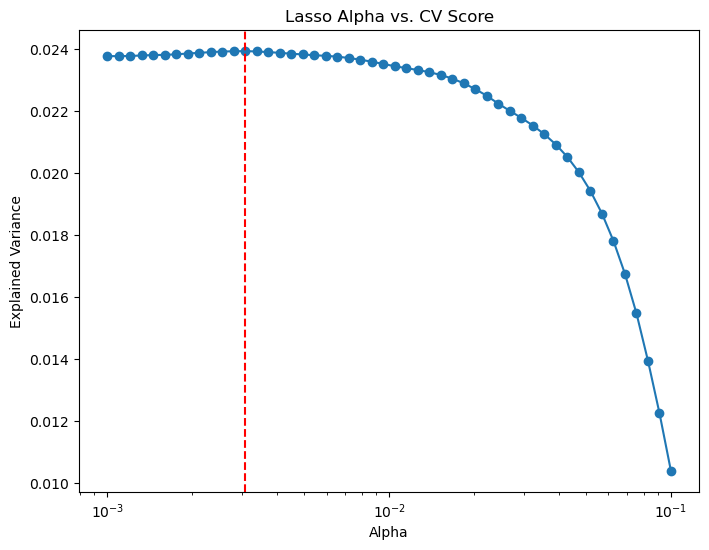

In [25]:
max_alpha = alphas[np.argmax(scores)]
# 绘制alpha与交叉验证分数的关系图
plt.style.use('default')
plt.figure(figsize=(8, 6))
plt.plot(alphas, scores, marker='o')
plt.axvline(x=max_alpha, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Explained Variance')
plt.title(f'Lasso Alpha vs. CV Score')
plt.show()

In [228]:
lasso = Lasso(alpha=max_alpha)
lasso.fit(concate_X, concate_y)

Lasso(alpha=0.003007882518043099)

In [30]:
from sklearn.model_selection import KFold
# 初始化9折交叉验证，保持样本顺序
kf = KFold(n_splits=9, shuffle=False)

# 创建Lasso模型实例
lasso = Lasso(alpha=max_alpha)

# 用于存储每次的性能指标
accuracy_scores = []
non_zero_features = []
# 进行9折交叉验证
for train_index, test_index in kf.split(concate_X):
    # 分割数据
    X_train, X_test = concate_X[train_index], concate_X[test_index]
    y_train, y_test = concate_y[train_index], concate_y[test_index]
    
    # 训练模型
    lasso.fit(X_train, y_train)
    
    #
    non_zero_features.append(np.where(lasso.coef_!=0)[0])

    # 预测测试集
    y_pred = lasso.predict(X_test)
    
    # 计算并记录性能指标
    accuracy_scores.append(np.corrcoef(y_test[:,0], y_pred)[0,1])

In [31]:
accuracy_scores

[0.12356521066141989,
 0.22531181873430045,
 0.161890284305094,
 0.16200671195707467,
 0.13025286887454354,
 0.15486534901515278,
 0.17330405656269093,
 0.1493654033628354,
 0.1190585768795085]

In [32]:
select_feature_intersection = set(list(range(64)))
for non_zero_feature in non_zero_features:
    select_feature_intersection = select_feature_intersection & set(non_zero_feature)

select_feature_intersection = sorted(list(select_feature_intersection))
print(select_feature_intersection)

[1, 9, 10, 16, 19, 26, 28, 33, 34, 40, 45, 58]


## subject loop

In [71]:
alphas

array([1.00000000e-02, 1.26638017e-02, 1.60371874e-02, 2.03091762e-02,
       2.57191381e-02, 3.25702066e-02, 4.12462638e-02, 5.22334507e-02,
       6.61474064e-02, 8.37677640e-02, 1.06081836e-01, 1.34339933e-01,
       1.70125428e-01, 2.15443469e-01, 2.72833338e-01, 3.45510729e-01,
       4.37547938e-01, 5.54102033e-01, 7.01703829e-01, 8.88623816e-01,
       1.12533558e+00, 1.42510267e+00, 1.80472177e+00, 2.28546386e+00,
       2.89426612e+00, 3.66524124e+00, 4.64158883e+00, 5.87801607e+00,
       7.44380301e+00, 9.42668455e+00, 1.19377664e+01, 1.51177507e+01,
       1.91448198e+01, 2.42446202e+01, 3.07029063e+01, 3.88815518e+01,
       4.92388263e+01, 6.23550734e+01, 7.89652287e+01, 1.00000000e+02])

sub-01 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.273e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.148e-01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

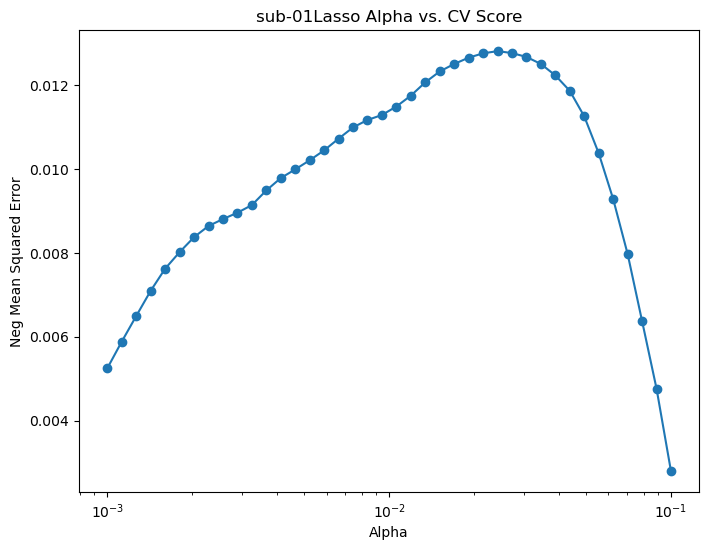

sub-02 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e+02, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e+02, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

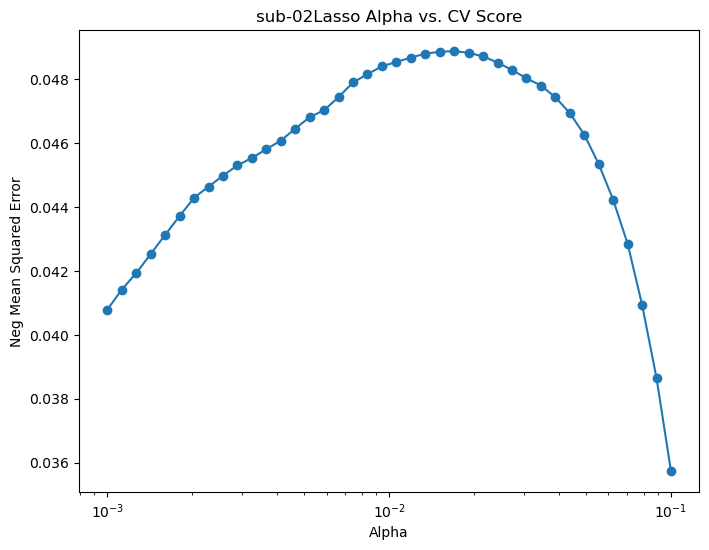

sub-03 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.638e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

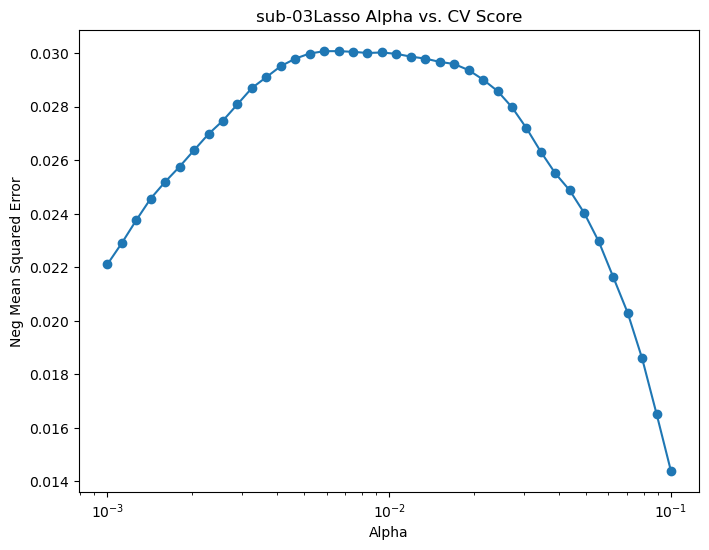

sub-04 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.506e-01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.658e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

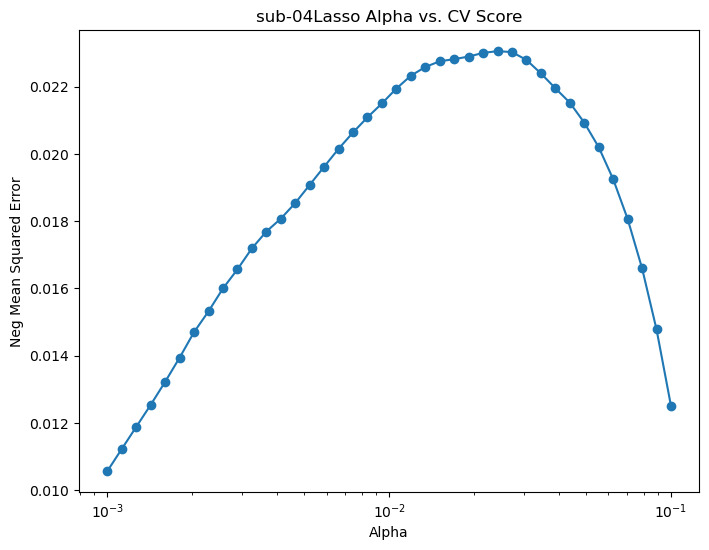

sub-05 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.773e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

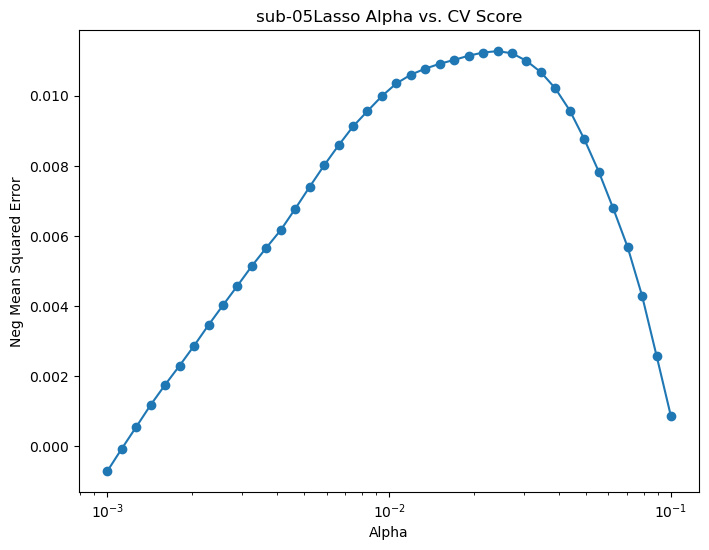

sub-06 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.654e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.669e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

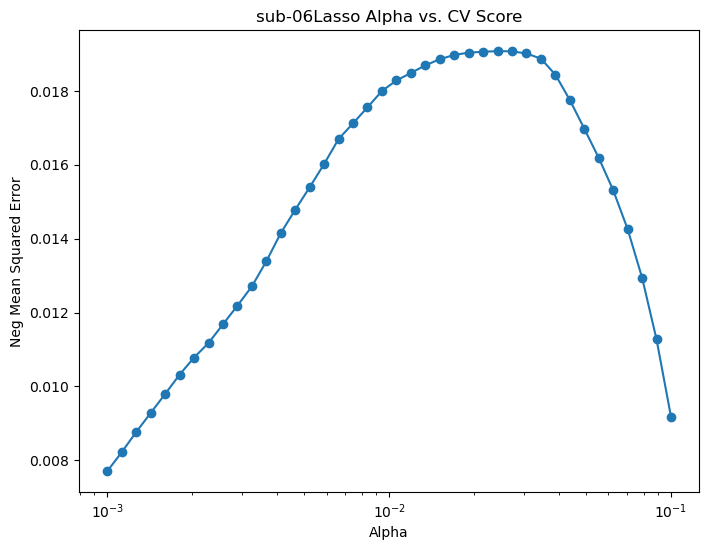

sub-07 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.614e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.444e-01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

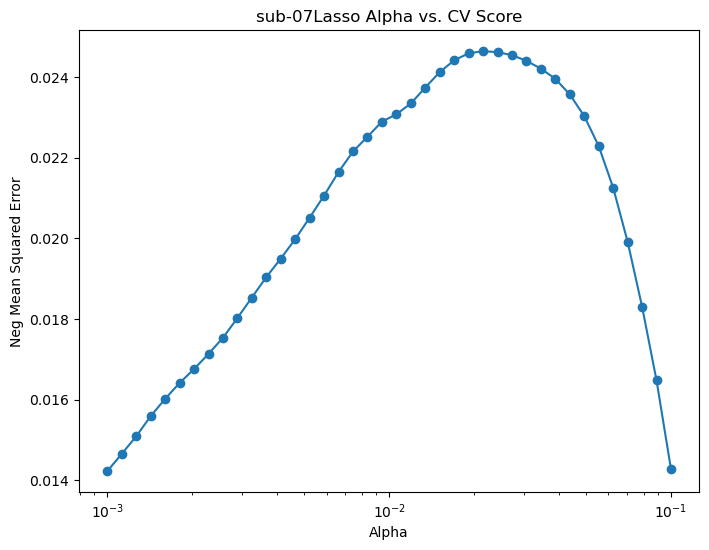

sub-08 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

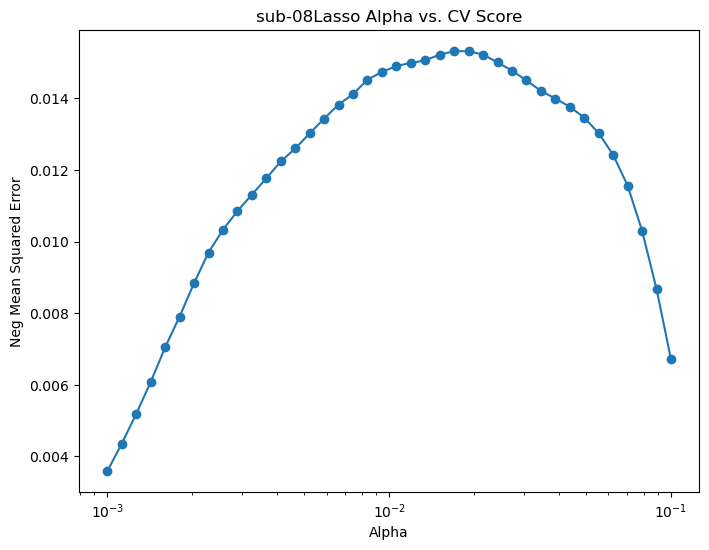

sub-09 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e+01, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.395e+00, tolerance: 3.000e-01
  model = cd_fast.enet_coordinate_descent(
/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

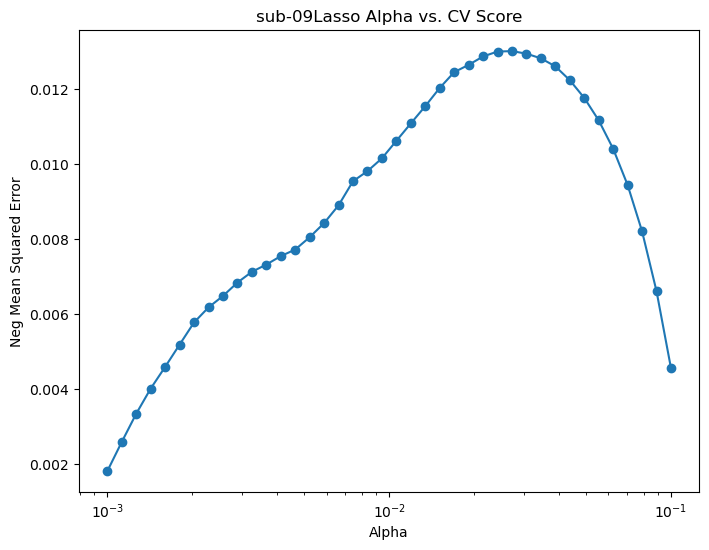

In [73]:
max_alphas = []
for sub in subs:

    print(sub, mask_name, layername)
    # sub dir
    prf_path = pjoin(opendata_cifti_pth, sub, 'results/ses-prf_task-prf')
    sub_prf_file = pjoin(prf_path, 'ses-prf_task-prf_params.dscalar.nii')
    # save path
    if not os.path.exists(pjoin(performance_path, sub)):
        os.makedirs(pjoin(performance_path, sub))

    # load and modify
    prf_data = nib.load(sub_prf_file).get_fdata()
    prf_r2 = prf_data[3,:]
    r2_thres = 10
    # make mask
    voxel_mask = prf_r2 > r2_thres
    # transfer mask into indices
    voxel_indices = np.where(voxel_mask==1)[0]

    # generate ROI in selected voxels
    v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxel_indices])
    v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxel_indices])
    v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxel_indices])
    v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxel_indices])

    # voxel masks
    early_vis_rois = [v1_voxels, v2_voxels, v3_voxels, v4_voxels]
    # average receptive field
    avg_receptivefield = np.load(pjoin(avgrf_path, f'{sub}_average-receptivefield.npy'))

    # load
    brain_resp = np.load(pjoin(resp_path, f'{sub}_imagenet_beta.npy'))
    activations = np.load(pjoin(image_activations_path, f'{sub}_{layername}.npy'))
    coco_activations = np.load(pjoin(image_activations_path, f'{test_set_name}_{layername}.npy'))
    print(f'activations shape of {activations.shape}')
    if 'conv1' in layername:
        guass_layername = layername.replace('conv1', 'conv2')
        guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'), allow_pickle=True)[0]
        print(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'))
    else:
        guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{layername}_Gauss.npy'), allow_pickle=True)[0]

    # load, reshape and average the resp
    test_resp = np.load(pjoin(resp_path, f'{sub}_{test_set_name}_beta.npy'))
    num_trial = test_resp.shape[0]
    num_run = int(num_trial/120)
    test_resp = test_resp.reshape((num_run, 120, 59412))
    mean_test_resp = test_resp.mean(axis=0)

    # collect resp and summed to ROI response
    roi_brain_resp = np.atleast_2d(brain_resp[:, v1_voxels].sum(axis=1)).T
    roi_mean_test_resp = np.atleast_2d(mean_test_resp[:, v1_voxels].sum(axis=1)).T

    # normalization
    norm_metric = 'session'
    roi_brain_resp = train_data_normalization(roi_brain_resp, metric=norm_metric)
    # mean_test_resp = zscore(test_resp.mean(axis=0))
    roi_mean_test_resp = zscore(roi_mean_test_resp, None)

    del test_resp, voxel_mask, brain_resp
    gc.collect()
    # coordinate
    # Create grid data
    layer['size'] = activations.shape[-1]
    i = np.linspace(-8., 8., layer['size'])
    j = np.linspace(8., -8., layer['size'])
    i, j = np.meshgrid(i, j)

    if layername == 'googlenet-conv2':
        X = activations[:, 0:63, :, :]
        X_test = coco_activations[:, 0:63, :, :]
    else:
        X = activations
        X_test = coco_activations

    X_avg = zscore(np.sum(X * avg_receptivefield, axis=(2,3)))
    X_test_avg = zscore(np.sum(X_test * avg_receptivefield, axis=(2,3)))

    y = roi_brain_resp
    y_test = roi_mean_test_resp
    # 自定义4-fold交叉验证
    cv = KFold(n_splits=4, shuffle=False)

    # 定义要测试的alpha值的范围
    alphas = np.logspace(-3, -1, 40)  # 创建一个覆盖广泛范围的alpha值
    scores = []  # 用于存储每个alpha对应的平均交叉验证分数

    # 对每个alpha进行评估
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        cv_scores = cross_val_score(lasso, X_avg, y, scoring='r2', cv=cv)
        scores.append(np.mean(cv_scores))
    max_alphas.append(alphas[np.argmax(scores)])
    # 绘制alpha与交叉验证分数的关系图
    plt.style.use('default')
    plt.figure(figsize=(8, 6))
    plt.plot(alphas, scores, marker='o')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Neg Mean Squared Error')
    plt.title(f'{sub}Lasso Alpha vs. CV Score')
    plt.show()

In [76]:
np.save(pjoin(performance_path, 'allsub_lasso-alphas.npy'), np.array(max_alphas))

In [77]:
max_alphas

[0.024244620170823284,
 0.017012542798525893,
 0.006614740641230145,
 0.024244620170823284,
 0.024244620170823284,
 0.024244620170823284,
 0.021544346900318832,
 0.017012542798525893,
 0.02728333376486768]

## subject training

In [37]:
isub, sub = 1, subs[1]
print(sub, mask_name, layername)
# sub dir
prf_path = pjoin(opendata_cifti_pth, sub, 'results/ses-prf_task-prf')
sub_prf_file = pjoin(prf_path, 'ses-prf_task-prf_params.dscalar.nii')
# save path
if not os.path.exists(pjoin(performance_path, sub)):
    os.makedirs(pjoin(performance_path, sub))

# load and modify
prf_data = nib.load(sub_prf_file).get_fdata()
prf_r2 = prf_data[3,:]
r2_thres = 10
# make mask
voxel_mask = prf_r2 > r2_thres
# transfer mask into indices
voxel_indices = np.where(voxel_mask==1)[0]

# generate ROI in selected voxels
v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxel_indices])
v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxel_indices])
v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxel_indices])
v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxel_indices])

# voxel masks
early_vis_rois = [v1_voxels, v2_voxels, v3_voxels, v4_voxels]
# average receptive field
avg_receptivefield = np.load(pjoin(avgrf_path, f'{sub}_average-receptivefield.npy'))

# load
brain_resp = np.load(pjoin(resp_path, f'{sub}_imagenet_beta.npy'))
activations = np.load(pjoin(image_activations_path, f'{sub}_{layername}.npy'))
coco_activations = np.load(pjoin(image_activations_path, f'{test_set_name}_{layername}.npy'))
print(f'activations shape of {activations.shape}')
if 'conv1' in layername:
    guass_layername = layername.replace('conv1', 'conv2')
    guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'), allow_pickle=True)[0]
    print(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'))
else:
    guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{layername}_Gauss.npy'), allow_pickle=True)[0]

# load, reshape and average the resp
test_resp = np.load(pjoin(resp_path, f'{sub}_{test_set_name}_beta.npy'))
num_trial = test_resp.shape[0]
num_run = int(num_trial/120)
test_resp = test_resp.reshape((num_run, 120, 59412))
mean_test_resp = test_resp.mean(axis=0)

# collect resp and summed to ROI response
roi_brain_resp = np.atleast_2d(brain_resp[:, v1_voxels].sum(axis=1)).T
roi_mean_test_resp = np.atleast_2d(mean_test_resp[:, v1_voxels].sum(axis=1)).T

# normalization
norm_metric = 'session'
roi_brain_resp = train_data_normalization(roi_brain_resp, metric=norm_metric)
# mean_test_resp = zscore(test_resp.mean(axis=0))
roi_mean_test_resp = zscore(roi_mean_test_resp, None)

del test_resp, voxel_mask, brain_resp
gc.collect()
# coordinate
# Create grid data
layer['size'] = activations.shape[-1]
i = np.linspace(-8., 8., layer['size'])
j = np.linspace(8., -8., layer['size'])
i, j = np.meshgrid(i, j)

if layername == 'googlenet-conv2':
    X = activations[:, 0:63, :, :]
    X_test = coco_activations[:, 0:63, :, :]
else:
    X = activations
    X_test = coco_activations

X_avg = np.sum(X * avg_receptivefield, axis=(2,3))
X_test_avg = np.sum(X_test * avg_receptivefield, axis=(2,3))

y = roi_brain_resp
y_test = roi_mean_test_resp
# 自定义4-fold交叉验证
cv = KFold(n_splits=4, shuffle=False)

# 
alpha = max_alphas[isub]  
scores = []  
lasso = Lasso(alpha=alpha)
cv_scores = cross_val_score(lasso, X_avg, y, scoring='r2', cv=cv)

sub-02 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)


In [43]:
lasso.fit(X_avg, y)

Lasso(alpha=7.684210526315789)

In [46]:
(lasso.coef_ !=0).sum()

12

In [80]:
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

val_scores = np.zeros((len(subs), 4))
val_corr = np.zeros((len(subs), 4))
max_alphas = np.load(pjoin(performance_path, 'allsub_lasso-alphas.npy'))

def pearson_correlation(y_true, y_pred):
    # 确保输入是NumPy数组
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # 确保输入是一维的
    if y_true.ndim > 1:
        y_true = np.ravel(y_true)
    if y_pred.ndim > 1:
        y_pred = np.ravel(y_pred)
    
    # 移除NaN值
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # 计算并返回皮尔森相关系数
    return pearsonr(y_true, y_pred)[0]

for isub, sub in enumerate(subs):

    print(sub, mask_name, layername)
    # sub dir
    prf_path = pjoin(opendata_cifti_pth, sub, 'results/ses-prf_task-prf')
    sub_prf_file = pjoin(prf_path, 'ses-prf_task-prf_params.dscalar.nii')
    # save path
    if not os.path.exists(pjoin(performance_path, sub)):
        os.makedirs(pjoin(performance_path, sub))

    # load and modify
    prf_data = nib.load(sub_prf_file).get_fdata()
    prf_r2 = prf_data[3,:]
    r2_thres = 10
    # make mask
    voxel_mask = prf_r2 > r2_thres
    # transfer mask into indices
    voxel_indices = np.where(voxel_mask==1)[0]

    # generate ROI in selected voxels
    v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxel_indices])
    v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxel_indices])
    v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxel_indices])
    v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxel_indices])

    # voxel masks
    early_vis_rois = [v1_voxels, v2_voxels, v3_voxels, v4_voxels]
    # average receptive field
    avg_receptivefield = np.load(pjoin(avgrf_path, f'{sub}_average-receptivefield.npy'))

    # load
    brain_resp = np.load(pjoin(resp_path, f'{sub}_imagenet_beta.npy'))
    activations = np.load(pjoin(image_activations_path, f'{sub}_{layername}.npy'))
    coco_activations = np.load(pjoin(image_activations_path, f'{test_set_name}_{layername}.npy'))
    print(f'activations shape of {activations.shape}')
    if 'conv1' in layername:
        guass_layername = layername.replace('conv1', 'conv2')
        guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'), allow_pickle=True)[0]
        print(pjoin(guass_path, f'{sub}_layer-{guass_layername}_Gauss.npy'))
    else:
        guassparams = np.load(pjoin(guass_path, f'{sub}_layer-{layername}_Gauss.npy'), allow_pickle=True)[0]

    # load, reshape and average the resp
    test_resp = np.load(pjoin(resp_path, f'{sub}_{test_set_name}_beta.npy'))
    num_trial = test_resp.shape[0]
    num_run = int(num_trial/120)
    test_resp = test_resp.reshape((num_run, 120, 59412))
    mean_test_resp = test_resp.mean(axis=0)

    # collect resp and summed to ROI response
    roi_brain_resp = np.atleast_2d(brain_resp[:, v1_voxels].sum(axis=1)).T
    roi_mean_test_resp = np.atleast_2d(mean_test_resp[:, v1_voxels].sum(axis=1)).T

    # normalization
    norm_metric = 'session'
    roi_brain_resp = train_data_normalization(roi_brain_resp, metric=norm_metric)
    # mean_test_resp = zscore(test_resp.mean(axis=0))
    roi_mean_test_resp = zscore(roi_mean_test_resp, None)

    del test_resp, voxel_mask, brain_resp
    gc.collect()
    # coordinate
    # Create grid data
    layer['size'] = activations.shape[-1]
    i = np.linspace(-8., 8., layer['size'])
    j = np.linspace(8., -8., layer['size'])
    i, j = np.meshgrid(i, j)

    if layername == 'googlenet-conv2':
        X = activations[:, 0:63, :, :]
        X_test = coco_activations[:, 0:63, :, :]
    else:
        X = activations
        X_test = coco_activations

    X_avg = zscore(np.sum(X * avg_receptivefield, axis=(2,3)))
    X_test_avg = zscore(np.sum(X_test * avg_receptivefield, axis=(2,3)))

    y = roi_brain_resp
    y_test = roi_mean_test_resp
    # 自定义4-fold交叉验证
    cv = KFold(n_splits=4, shuffle=False)

    # 
    alpha = max_alphas[isub]  
    lasso = Lasso(alpha=alpha)
    cv_scores = cross_val_score(lasso, X_avg, y, scoring='r2', cv=cv)
    val_scores[isub,:] = cv_scores

    # 创建一个scorer对象
    pearson_scorer = make_scorer(pearson_correlation, greater_is_better=True)
    cv_corrs = cross_val_score(lasso, X_avg, y, scoring=pearson_scorer, cv=cv)
    val_corr[isub,:] = cv_corrs

    # fit the model
    lasso.fit(X_avg, y)
    joblib.dump(lasso, pjoin(performance_path, f'{sub}_lasso-model.pkl'))
    print(f'save {sub} lasso model with {np.sum(lasso.coef_ != 0)} non-zero beta')

sub-01 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
save sub-01 lasso model with 8 non-zero beta
sub-02 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
save sub-02 lasso model with 14 non-zero beta
sub-03 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
save sub-03 lasso model with 23 non-zero beta
sub-04 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
save sub-04 lasso model with 8 non-zero beta
sub-05 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
save sub-05 lasso model with 7 non-zero beta
sub-06 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
save sub-06 lasso model with 11 non-zero beta
sub-07 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
save sub-07 lasso model with 10 non-zero beta
sub-08 primaryvis-in-MMP googlenet-conv2
activations shape of (4000, 64, 57, 57)
save sub-08 lasso model with 14 n

In [82]:
max_alphas

array([0.02424462, 0.01701254, 0.00661474, 0.02424462, 0.02424462,
       0.02424462, 0.02154435, 0.01701254, 0.02728333])

In [66]:
np.save(pjoin(performance_path, 'allsub_val-corr.npy'), val_corr)
np.save(pjoin(performance_path, 'allsub_val-ev.npy'), val_scores)

In [65]:
joblib.dump(lasso, pjoin(performance_path, f'{sub}_lasso-model.pkl'))

['/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/featurewise-corr/lass-feature-selection/sub-09_lasso-model.pkl']

In [83]:
non_zeros_num = []
for sub in subs:
    lasso_load = joblib.load(pjoin(performance_path, f'{sub}_lasso-model.pkl'))
    # print(sub, np.where(lasso_load.coef_!=0))
    non_zeros_num.append((lasso_load.coef_!=0).sum())

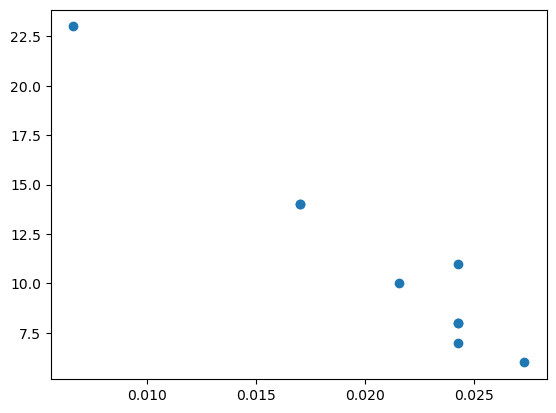

In [84]:
plt.scatter(max_alphas, non_zeros_num)